In [1]:
using ReinforcementLearning, ReinforcementLearningEnvironments

In [2]:
using Plots, StatsBase

In [3]:
function gen_model(ns, na, nb, termination_prob)
    transitions = rand(1:ns, ns, na, nb)
    rewards = randn(ns, na, nb)
    function f(s, a)
        [(next_state = transitions[s, a, b],
          reward     = rewards[s, a, b],
          isdone     = rand() < termination_prob,
          prob       = 1/nb)
          for b in 1:nb]
    end
    DynamicDistributionModel(f, ns, na)
end

gen_model (generic function with 1 method)

In [4]:
function eval_Q(Q, M, S=EpsilonGreedySelector(0.))
    s, isdone, reward = 1, false, 0.
    while !isdone
        a = Q(s) |> S
        next_options = M(s, a)
        s′, r, isdone, _ = sample(next_options, weights([x.prob for x in next_options]))
        reward += r
        s = s′
    end
    reward
end

eval_Q (generic function with 2 methods)

In [5]:
function alternate_policy(ns, na, nb, steps=20000, eval_every=100, termination_prob=0.1)
    Q = TabularQApproximator(n_state=ns, n_action=na)
    M = gen_model(ns, na, nb, termination_prob)
    rewards = []
    step = 1
    while step <= steps
        for s in 1:ns
            for a in 1:na
                error = sum(p * (r + (1-d) * maximum(Q(s′))) for (s′, r, d, p) in M(s, a)) - Q(s, a)
                update!(Q, (s, a) => error)
                step % eval_every == 0 && push!(rewards, mean(eval_Q(Q, M) for _ in 1:1000))
                step += 1
            end
        end
    end
    rewards
end

alternate_policy (generic function with 4 methods)

In [6]:
function on_policy(ns, na, nb, steps=20000, eval_every=100, ϵ=0.1, termination_prob=0.1)
    Q = TabularQApproximator(n_state=ns, n_action=na)
    S = EpsilonGreedySelector(ϵ)
    M = gen_model(ns, na, nb, termination_prob)
    s = 1
    rewards = []
    for step in 1:steps
        a = Q(s) |> S
        next_options = M(s, a)
        next_state, _, isdone, _ = sample(next_options, weights([x.prob for x in next_options]))
        error = sum(p * (r + (1-d) * maximum(Q(s′))) for (s′, r, d, p) in next_options) - Q(s, a)
        update!(Q, (s, a) => error)
        s = isdone ? 1 : next_state
        step % eval_every == 0 && push!(rewards, mean(eval_Q(Q, M) for _ in 1:1000))
    end
    rewards
end

on_policy (generic function with 5 methods)

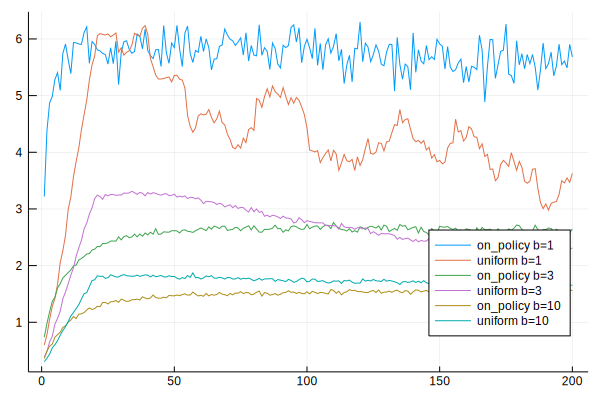

In [7]:
p = plot(legend=:bottomright)
ns, na, steps, eval_every = 1000, 2, 20000, 100
for b in [1, 3, 10]
    plot!(p, mean(on_policy(ns, na, b, steps, eval_every) for _ in 1:30), label="on_policy b=$b")
    plot!(p, mean(alternate_policy(ns, na, b, steps, eval_every) for _ in 1:30), label="uniform b=$b")
end

p

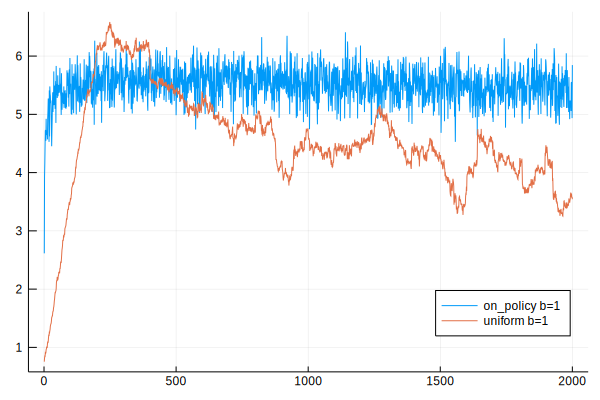

In [8]:
ns, b, steps = 10000, 1, 200000
p = plot(legend=:bottomright)
plot!(p, mean(on_policy(ns, na, b, steps, eval_every) for _ in 1:30), label="on_policy b=$b")
plot!(p, mean(alternate_policy(ns, na, b, steps, eval_every) for _ in 1:30), label="uniform b=$b")
p